In [1]:
import keras
import keras_tuner
import matplotlib.pyplot as plt

IMAGE_SIZE = (71, 71)
BATCH_SIZE = 256
TEST_SIZE = 0.4
VAL_SIZE = 0.2
DATA_DIR = "data"
ID_DRIVE = {
    "empty": "1NH3MTPqwPk25Zz127D6SP45dNnFkQB5e&confirm=t",
    "crossedout": "19_8vPdpYqO1WrM5gbchrRNDEXxjiIKLC&confirm=t",
    "confirmed": "1iQ8x12DvT7s15IUDegI87aJtcUMECXqU&confirm=t",
}
EPOCHS = 5

In [2]:
tb_callback = keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

In [3]:
import os
import pathlib
import tempfile
from functools import partial
from zipfile import ZipFile

import gdown
import numpy as np
import tensorflow as tf


def obtain_data(directory="data"):
    if os.path.exists(directory):
        print(f"O diretório {directory} já existe, pulando o download dos dados.")
        return

    with tempfile.TemporaryDirectory() as tmpdirname:
        print("created temporary directory", tmpdirname)
        for name, id in ID_DRIVE.items():
            gdown.download(id=id, output=os.path.join(tmpdirname, f"{name}.zip"))

        for file in os.listdir(tmpdirname):
            with ZipFile(os.path.join(tmpdirname, file), "r") as zip:
                zip.extractall(path=directory)


def get_label(file_path, class_names):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


def decode_img(img, img_size):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, img_size)


def process_path(file_path, class_names, img_size):
    label = get_label(file_path, class_names)
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_size)
    return img, label


def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


def train_test_val_img_dataset(
    directory="data", seed=1337, test_size=0.2, val_size=0.2, batch_size=32, image_size=(224, 224)
):
    data_dir = pathlib.Path(directory).with_suffix("")

    list_ds = tf.data.Dataset.list_files(str(data_dir / "*/*"), shuffle=False)
    image_count = list_ds.cardinality().numpy()
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False, seed=seed)

    class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

    train_ds = list_ds.skip(test_size * image_count + val_size * image_count)
    val_ds = list_ds.take(val_size * image_count)
    test_ds = list_ds.skip(val_size * image_count).take(test_size * image_count)

    process_path_p = partial(process_path, class_names=class_names, img_size=image_size)

    train_ds = train_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = configure_for_performance(train_ds, batch_size)
    val_ds = configure_for_performance(val_ds, batch_size)
    test_ds = configure_for_performance(test_ds, batch_size)

    return train_ds, test_ds, val_ds, class_names


def count_labels(ds):
    label_counts = {}
    for _, labels in ds:
        labels_numpy = labels.numpy()

        for label_value in labels_numpy:
            label_value = int(label_value)
            if label_value in label_counts:
                label_counts[label_value] += 1
            else:
                label_counts[label_value] = 1
    return label_counts


def generate_class_weigths(class_counts):
    total_samples = sum(class_counts.values())
    class_weights = {}
    # Pesos para cada classe (inversamente proporcionais às frequências)
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights


## Carga dos dados

Os dados usados para a construção do modelo são do conjunto [MC Answer Boxes Dataset](https://sites.google.com/view/mcq-dataset), que contém diversos testes de múltipla escolha respondidos. Neste conjunto de dados, já temos as caixas de resposta de cada teste extraída e com a marcação entre "confirmada", "vazia" ou "cancelada".

Os dados estão disponíveis publicamente no Google Drive, e é possível fazer o download automático usando o pacote `gdown`.

Um diretório temporário é criado, os arquivos são baixados do Google Drive para este diretório e então são descompactados criando a pasta data.

Dentro da pasta data, são criados diretórios para cada classe ("confirmed", "empty" e "crossedout").


In [4]:
obtain_data(DATA_DIR)

O diretório data já existe, pulando o download dos dados.


## Leitura do dataset

Os dados serão divididos em três partes:

1. **Treino** : Dados que serão utilizados para treinar o modelo.
2. **Validação**: Dados que serão utilizados para avaliar o modelo durante o treinamento.
3. **Teste**: Dados que serão utilizados para avaliar o modelo após o treinamento.

A separação em validação e teste garante que a avaliação do modelo será feita com dados que não foram vistos em nenhum momento durante o treinamento - nem mesmo na validação.


In [5]:
train_ds, test_ds, val_ds, class_names = train_test_val_img_dataset(
    DATA_DIR, test_size=TEST_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=1337
)

Os dados são referentes a imagens das caixas de resposta extraídas de testes de múltipla escolha. Cada imagem é de uma caixa de resposta, e a marcação da caixa é feita como "confirmed" (confirmada), "empty" (vazia) ou "crossedout" (cancelada).


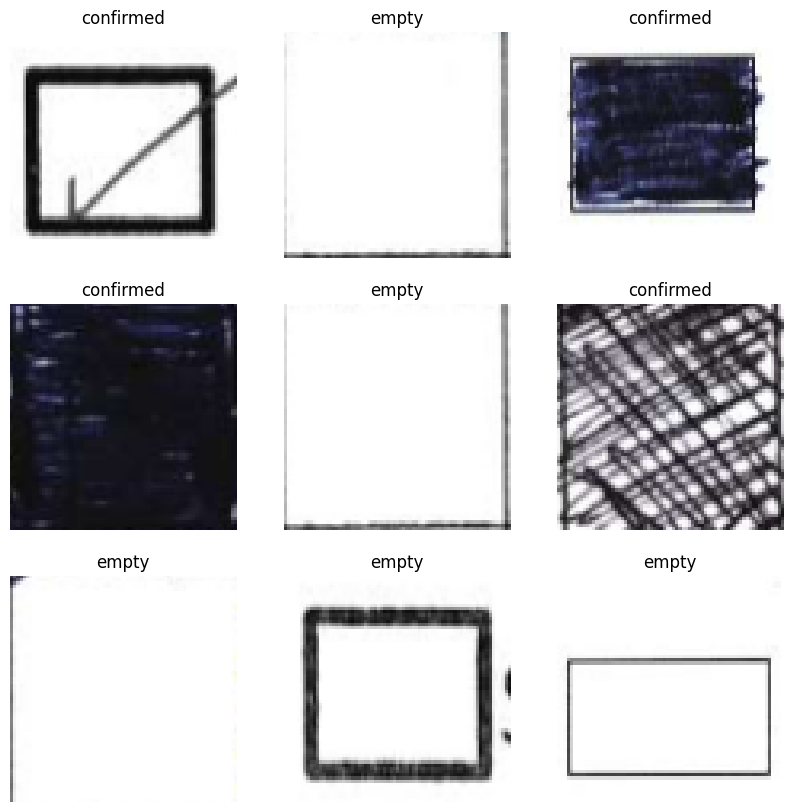

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

Geralmente, quando respondendo um teste de múltipla escolha, não é muito frequente as vezes em que cancelamos uma resposta. Portanto, é esperado que a classe "crossedout" possua uma frequência menor que as outras classes.

Além disso, testes múltiplas escolhas usualmente possuem mais do que duas alteranativas, com apenas uma delas sendo a alternativa correta. Portanto, também é esperado que a classe "empty" possua uma frequência menor que a classe "confirmed".

In [7]:
train_class_freq = count_labels(train_ds)

{class_names[k]: v for k, v in train_class_freq.items()}

{'empty': 9000, 'confirmed': 4333, 'crossedout': 87}

Para corrigir esse desbalanceamento, uma possível alternativa é aumentar o peso dessa classe durante o treinamento do modelo.

In [8]:
class_weights = generate_class_weigths(train_class_freq)
{class_names[k]: v for k, v in class_weights.items()}

{'empty': 0.49703703703703705,
 'confirmed': 1.0323871067005155,
 'crossedout': 51.417624521072796}

## Definição do modelo

O modelo utilizado é um modelo treinado usando trasnfer learning com o modelo Xception.

Foi incluído um passo de preprocessamento para ajustar o tamanho das imagens para o tamanho desejado pelo modelo.
Por mais que os conjuntos de dados usados no treino e no teste já estejam com o tamanho correto, no momento da previsão podem ser passadas imagens de qualquer tamanho que serão ajustadas para o tamanho correto.

Além disso, foi incluído um passo de normalização, que ajusta os valores para o intervalo [-1, 1].


In [9]:
def make_model(input_shape, num_classes, dropout, learning_rate):
    base_model = keras.applications.Xception(
        weights="imagenet",
        input_shape=input_shape + (3,),
        include_top=False,
    )
    base_model.trainable = False

    inputs = keras.Input(shape=[None, None, 3])
    # Step de preprocessamento para ajudar na previsão - isso me permite
    # usar imagens de qualquer tamanho na hora de realizar a previsão.
    naive_resize = keras.layers.Resizing(*input_shape)(inputs)

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(naive_resize)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    if dropout:
        x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )
    return model

## Otimização dos hiperparâmetros

Foram escolhidos para otimização os seguintes hiperparâmetros:

1. Learning rate: Taxa de aprendizado do modelo.
2. Dropout: Utilização ou não de dropout.

A otimização é realizada utilizando uma busca aleatória no espaço de hiperparâmetros, com no máximo 5 tentativas.

In [10]:
def build_model(hp):
    input_shape = IMAGE_SIZE
    num_classes = len(class_names)
    dropout = hp.Boolean("dropout")
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model = make_model(input_shape, num_classes, dropout, learning_rate)
    return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_acc",
    max_trials=5,
    project_name="otimizacao_hiperparametros",
    seed=1337,
    overwrite=True,
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
tuner.search(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[tb_callback],
)

Trial 5 Complete [00h 09m 34s]
val_acc: 0.953197181224823

Best val_acc So Far: 0.9791325330734253
Total elapsed time: 00h 48m 10s


Resumo da busca pelos melhores hiperparâmetros:

In [12]:
tuner.results_summary()

Results summary
Results in .\otimizacao_hiperparametros
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 2 summary
Hyperparameters:
dropout: False
learning_rate: 0.004823073949081142
Score: 0.9791325330734253

Trial 0 summary
Hyperparameters:
dropout: True
learning_rate: 0.005421195615159703
Score: 0.9761514663696289

Trial 1 summary
Hyperparameters:
dropout: True
learning_rate: 0.0005065312024231252
Score: 0.9587121605873108

Trial 3 summary
Hyperparameters:
dropout: False
learning_rate: 0.0006818920464866776
Score: 0.9563273191452026

Trial 4 summary
Hyperparameters:
dropout: False
learning_rate: 0.000396478365712187
Score: 0.953197181224823


## Ajuste do modelo

Após obter a melhor combinação de hiperparâmetros, o modelo pode ser treinado novamente, com a melhor combinação dos hiperparâmetros.

In [13]:
best_hps = tuner.get_best_hyperparameters(1)
model = build_model(best_hps[0])
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, None, None, 3) │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resizing_1 (Resizing)       │ (None, 71, 71, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 71, 71, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 3, 3, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

O modelo é salvo a cada época através do callback ModelCheckpoint. Se a *validation loss* parar de diminuir, o treinamento é interrompido de forma antecipada através do callback EarlyStopping. Além disso, são salvos logs para visualização do treinamento no TensorBoard.

In [14]:
if not os.path.exists("models"):
    os.makedirs("models")

callbacks = [
    keras.callbacks.ModelCheckpoint("models/checkpoint/save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    tb_callback,
]

model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds, class_weight=class_weights)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - acc: 0.7565 - loss: 0.7609 - val_acc: 0.9055 - val_loss: 0.3741
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - acc: 0.9554 - loss: 0.2216 - val_acc: 0.9626 - val_loss: 0.2056
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - acc: 0.9604 - loss: 0.1733 - val_acc: 0.9815 - val_loss: 0.1147
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - acc: 0.9779 - loss: 0.1532 - val_acc: 0.9647 - val_loss: 0.1638
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - acc: 0.9800 - loss: 0.1031 - val_acc: 0.9742 - val_loss: 0.1292


A performance do modelo é avaliada no conjunto de teste.

In [16]:
results = model.evaluate(
    test_ds,
    callbacks=[tb_callback],
)
print(f"Test dataset: \n\nloss     - {results[0]:.4f}\naccuracy - {(results[1]*100):.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - acc: 0.9712 - loss: 0.1392


O conjunto de dados de teste e o modelo treinado são salvos para uso posterior pela API.

In [30]:
test_ds.save("datasets/ds_test")
model.save("models/omr_model.keras")